1. Load modules and data


In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=0de0650cb516928a5e8f810b978922547e632efa118e2a8d27a0bf67011bd4e6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 152.3 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


In [0]:
!kill -9 -1

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
import cv2
! pip install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.cluster import KMeans
from skimage import io, color

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 640.6MB 27kB/s 
     |████████████████████████████████| 4.0MB 57.1MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
PyTorch Version:  1.4.0+cu92
Torchvision Version:  0.5.0+cu92
Using the GPU!


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q "/content/drive/My Drive/ImageNet.zip"

In [0]:
data_dir = "./ImageNet"
mean = [0.5,0.5,0.5]
std = [0.5,0.5,0.5]
batch_size = 1
input_size = 128
data_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.ToTensor(),transforms.Normalize(mean,std)])
dataset = datasets.ImageFolder(data_dir, transform=data_transform)
train_set, test_set, rest = torch.utils.data.random_split(dataset, [5,2,6393])
train_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_data = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

torch.Size([1, 3, 128, 128])


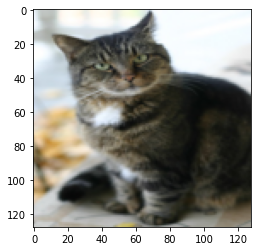

In [0]:
inputs, classes = next(iter(train_data))
print(inputs.shape)
inputs = 0.5*(inputs +1)
out = torchvision.utils.make_grid(inputs, nrow=4)
out = np.transpose(out, (1, 2, 0))
plt.imshow(out)

In [0]:
lab = color.rgb2lab(out)

2. Data Process and Helper functions

In [0]:
# and other data process help functions

# Color space conversion 
# honor code https://github.com/richzhang/colorization-pytorch/blob/b7612f6d2e523d629ef09630f7e43c8ed09e3c42/util/util.py#L202
def rgb2xyz(rgb): 
    '''
    input: rgb images, (N,3,H,W)
    output: xyz images, (N,3,H,W)
    xyz_from_rgb = np.array([[0.412453, 0.357580, 0.180423],
                 [0.212671, 0.715160, 0.072169],
                 [0.019334, 0.119193, 0.950227]])
    ''' 
    mask = (rgb > 0.04045).type(torch.FloatTensor).cuda()
        
    rgb = (((rgb+0.055)/1.055)**2.4)*mask + rgb/12.92*(1-mask)

    x = 0.412453*rgb[:,0,:,:]+0.357580*rgb[:,1,:,:]+0.180423*rgb[:,2,:,:]
    y = 0.212671*rgb[:,0,:,:]+0.715160*rgb[:,1,:,:]+0.072169*rgb[:,2,:,:]
    z = 0.019334*rgb[:,0,:,:]+0.119193*rgb[:,1,:,:]+0.950227*rgb[:,2,:,:]
    out = torch.cat((x[:,None,:,:],y[:,None,:,:],z[:,None,:,:]),dim=1)
    return out

def xyz2lab(xyz):
    '''
    input: xyz images, (N,3,H,W)
    output: lab images, (N,3,H,W)
    ''' 
    sc = torch.Tensor((0.95047, 1., 1.08883))[None,:,None,None].cuda()

    xyz_scale = xyz/sc
    mask = (xyz_scale > .008856).type(torch.FloatTensor).cuda()
    xyz_int = xyz_scale**(1/3.)*mask + (7.787*xyz_scale + 16./116.)*(1-mask)

    L = 116.*xyz_int[:,1,:,:]-16.
    a = 500.*(xyz_int[:,0,:,:]-xyz_int[:,1,:,:])
    b = 200.*(xyz_int[:,1,:,:]-xyz_int[:,2,:,:])
    out = torch.cat((L[:,None,:,:],a[:,None,:,:],b[:,None,:,:]),dim=1)
    return out 

def rgb2lab(data):
    '''
    input: rgb images, (N,3,H,W)
    output: lab images, (N,3,H,W)
    ''' 
    lab = xyz2lab(rgb2xyz(data))
    # colorization normalization
    l_rs = (lab[:,[0],:,:]-l_cent)/l_norm
    ab_rs = lab[:,1:,:,:]/ab_norm
    out = torch.cat((l_rs,ab_rs),dim=1)
    return out


3. Networks   
Based on the paper, the Main Colorization Network(a U-net):  
Encoder:     
(C64-C64)-(C128-C128)-(C256-C256-C256)-(C512-C512-C512)-(C512-C512-C512)-(C512-C512-C512)   
Decoder:     
(C512-C512-C512)-(C256-C256-C256)-(C128-C128)-(C128-C128)


In [0]:
def normal_init(m, mean, std):
    """
    Helper function. Initialize parameter with given mean and std.
    """
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):

        nn.init.normal_(m.weight, mean=mean, std=std)
        nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

In [0]:
# 3.1 Main Colorization Network (U-net)
class UnetGenerator(nn.Module):
    def __init__(self, input_c, output_c):
        super(UnetGenerator, self).__init__()

        self.conv_1_1 = nn.Sequential(nn.Conv2d(input_c, 64, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())
        self.conv_1_2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=1), nn.ReLU(),
                        nn.BatchNorm2d(64))
        # self.conv_1_sub = nn.Sequential(nn.MaxPool2d(kernel_size=(4,4), stride=2, padding=1))

        self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128))
        # self.conv_2_sub = nn.Sequential(nn.MaxPool2d(kernel_size=(4,4), stride=2))

        self.conv_3_1 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())
        self.conv_3_2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())
        self.conv_3_3 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=1), nn.ReLU(),
                        nn.BatchNorm2d(256))
        # self.conv_3_sub = nn.Sequential(nn.MaxPool2d(kernel_size=(4,4), stride=2))

        self.conv_4_1 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())
        self.conv_4_2 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())
        self.conv_4_3 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=1), nn.ReLU(),
                        nn.BatchNorm2d(512))
        
        self.conv_5_1 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=2, dilation=2), nn.ReLU())
        self.conv_5_2 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=2, dilation=2), nn.ReLU())
        self.conv_5_3 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=2, dilation=2), nn.ReLU(),
                      nn.BatchNorm2d(512))
        
        self.conv_6_1 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=2, dilation=2), nn.ReLU())
        self.conv_6_2 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=2, dilation=2), nn.ReLU())
        self.conv_6_3 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=2, dilation=2), nn.ReLU(),
                      nn.BatchNorm2d(512))
        
        self.conv_7_1 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())
        self.conv_7_2 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())
        self.conv_7_3 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(3,3), stride=1, padding=1), nn.ReLU(),
                        nn.BatchNorm2d(512))
                        
        self.conv_8_1_1 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=(4,4), stride=2, padding=1))
        self.conv_8_1_2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=1))
        self.conv_8_1_3 = nn.Sequential(nn.ReLU())
        self.conv_8_2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())
        self.conv_8_3 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=1), nn.ReLU(),
                        nn.BatchNorm2d(256))
        
        self.conv_9_1_1 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=(4,4), stride=2, padding=1))
        self.conv_9_1_2 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1))
        self.conv_9_1_3 = nn.Sequential(nn.ReLU())
        self.conv_9_2 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1), nn.ReLU(),
                        nn.BatchNorm2d(128))
        
        self.conv_10_1_1 = nn.Sequential(nn.ConvTranspose2d(128, 128, kernel_size=(4,4), stride=2, padding=1))
        self.conv_10_1_2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1))
        self.conv_10_1_3 = nn.Sequential(nn.ReLU())
        self.conv_10_2 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1), nn.LeakyReLU(0.2))
        
        self.final = nn.Sequential(
            nn.Conv2d(128, output_c, kernel_size=(1,1), stride=1, padding=0),
            nn.Tanh())
        
        self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'),nn.ReLU())


    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input_L, Local=None, Global=None):
        # input_L : (N,1,H,W)
        # Local : (N,64,H,W)
        # Global : (N,512,1,1)
        conv_1_1 = self.conv_1_1(input_L)
        if Local != None:
            conv_1_1 = conv_1_1 + Local
        conv_1_2 = self.conv_1_2(conv_1_1)
        # conv_1_sub = self.conv_1_sub(conv_1_2)
        conv_1_sub = conv_1_2[:,:,::2,::2]

        conv_2 = self.conv_2(conv_1_sub)
        # conv_2_sub = self.conv_2_sub(conv_2)
        conv_2_sub = conv_2[:,:,::2,::2]

        conv_3_1 = self.conv_3_1(conv_2_sub)
        conv_3_2 = self.conv_3_2(conv_3_1)
        conv_3_3 = self.conv_3_3(conv_3_2)
        # conv_3_sub = self.conv_3_sub(conv_3_3)
        conv_3_sub = conv_3_3[:,:,::2,::2]

        conv_4_1 = self.conv_4_1(conv_3_sub)
        conv_4_2 = self.conv_4_2(conv_4_1)
        conv_4_3 = self.conv_4_3(conv_4_2)
        if Global != None:
            global_repeat = torch.ones_like(conv_4_3).cuda()
            conv_4_3 = conv_4_3 + global_repeat * Global
        
        conv_5_1 = self.conv_5_1(conv_4_3)
        conv_5_2 = self.conv_5_2(conv_5_1)
        conv_5_3 = self.conv_5_3(conv_5_2)

        conv_6_1 = self.conv_6_1(conv_5_3)
        conv_6_2 = self.conv_6_2(conv_6_1)
        conv_6_3 = self.conv_6_3(conv_6_2)

        conv_7_1 = self.conv_7_1(conv_6_3)
        conv_7_2 = self.conv_7_2(conv_7_1)
        conv_7_3 = self.conv_7_3(conv_7_2)

        a = self.conv_8_1_1(conv_7_3)
        b = self.conv_8_1_2(conv_3_3)
        conv_8_1 = self.conv_8_1_3(a+b)
        conv_8_2 = self.conv_8_2(conv_8_1)
        conv_8_3 = self.conv_8_3(conv_8_2)

        conv_9_1 = self.conv_9_1_3(self.conv_9_1_1(conv_8_3) + self.conv_9_1_2(conv_2))
        conv_9_2 = self.conv_9_2(conv_9_1)
        
        conv_10_1 = self.conv_10_1_3(self.conv_10_1_1(conv_9_2) + self.conv_10_1_2(conv_1_2))
        conv_10_2 = self.conv_10_2(conv_10_1)

        colorization_out = self.final(conv_10_2)

        dis_conv3 = torch.cat((conv_3_1[:,::2,:,:],conv_3_2[:,::2,:,:],conv_3_3[:,::2,:,:]),dim=1)
        dis_conv8 = torch.cat((conv_8_1[:,::2,:,:],conv_8_2[:,::2,:,:],conv_8_3[:,::2,:,:]),dim=1)
        dis_conv4 = torch.cat((conv_4_1[:,::4,:,:],conv_4_2[:,::4,:,:],conv_4_3[:,::4,:,:]),dim=1)
        dis_conv5 = torch.cat((conv_5_1[:,::4,:,:],conv_5_2[:,::4,:,:],conv_5_3[:,::4,:,:]),dim=1)
        dis_conv6 = torch.cat((conv_6_1[:,::4,:,:],conv_6_2[:,::4,:,:],conv_6_3[:,::4,:,:]),dim=1)
        dis_conv7 = torch.cat((conv_7_1[:,::4,:,:],conv_7_2[:,::4,:,:],conv_7_3[:,::4,:,:]),dim=1)
        dis_4567 = self.up(torch.cat((dis_conv4,dis_conv5,dis_conv6,dis_conv7),dim=1))
        distribution_out = torch.cat((dis_conv3,dis_4567,dis_conv8),dim=1)

        return colorization_out, distribution_out



In [0]:

# 3.2 Local Hint Network/color distribution

class LH(nn.Module):
  def __init__(self):
    super(LH, self).__init__()
    self.ul = nn.Sequential(nn.Conv2d(3, 64, kernel_size=(3,3), stride=1, padding=1), nn.ReLU())

    # two-layer color distribution
    self.classifier = nn.Sequential(
        nn.Linear(384*6, 1000),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(1000,313),
        nn.Softmax(dim=1)
    )
    self.up = nn.Sequential(nn.Upsample(scale_factor=4, mode='bilinear',align_corners=True))

  def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
  def forward(self, input_dis=None, input_user=None):
    # input_dis: (N, 384*6, H/4, W/4)
    # input_user: (N, 3, H, W)
    # o : (N, 313, H, W)
    # uh : (N, 64, H, W)
    uh = None
    if input_user != None:
      uh = self.ul(input_user)
    o = None
    if input_dis != None:
      N, C, H, W = input_dis.shape
      input_dis = input_dis.view(N,H,W,C)
      o = self.classifier(input_dis)
      o = o.view(N,-1,H,W)
      o = self.up(o)
    return o, uh


In [0]:
# 3.3 Global Hint Network

class GH(nn.Module):
    def __init__(self):
        super(GH, self).__init__()
        self.ug = nn.Sequential(
            nn.Conv2d(316,512,kernel_size=(1,1)),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=(1,1)),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=(1,1)),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=(1,1)),
            nn.ReLU()
        )
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
      
    def forward(self, glob_hint=None):
        # glob_hint : (N,316,1,1)
        glob=None
        if glob_hint != None:
            glob = self.ug(glob_hint)
        return glob


In [0]:
# 3.4 Loss functions

# 3.4.1 Regression Loss (Y' and Y)
def color_loss(color_pred, image_ab):
    # color_pred : (N, 2, H, W)
    # image_ab : (N, 2, H, W)
    delta = 1

    diff = color_pred - image_ab
    mask = (abs(diff) < delta)
    loss = torch.sum(diff**2*mask/2 + delta*(diff - delta/2)*~mask)
    return loss


# 3.4.2 Cross-Entropy Loss (Z' and Z)
def distr_loss(distr_pred, distr_gt):
    # distr_pred : (N, Q, H, W)
    # distr_gt : (N, H, W)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(distr_pred, distr_gt)
    return loss
  

4. Simulate User Interactions & Global Hint

In [0]:
# Simulate User hint Position(randomly sampling from a 2-D Gaussian)
def get_user_hint(data):
  '''
  input: data - ab images, (N,2,H,W)
  output: user_hint, (N,3,H,W)
  ''' 
  N,_,H,W = data.shape
  x_hint = torch.zeros_like(data).cuda()
  mask = torch.zeros(N,1,H,W).cuda()

  for n in range(N):
    if torch.rand(1) < 0.01:
      x_hint = data
      mask[:,:,:,:] = 1.
    else:
      while True:
        picked = torch.rand(1) > p
        if not picked:
          break

        ps = torch.tensor(np.random.choice([1,2,3,4,5,6,7,8,9]))
        # draw locations from 2-D gaussian
        h = int(np.clip(np.random.normal((H-ps+1)/2., (H-ps+1)/4.), 0, H-ps))
        w = int(np.clip(np.random.normal((W-ps+1)/2., (W-ps+1)/4.), 0, W-ps))
        # average over patch
        x_hint[n,:,h:h+ps,w:w+ps] = torch.mean(torch.mean(data[n,:,h:h+ps,w:w+ps],dim=2,keepdim=True),dim=1,keepdim=True).view(1,2,1,1)
        mask[n,:,h:h+ps,w:w+ps] = 1.
  mask -= mask_cent
  user_hint = torch.cat((x_hint,mask),dim=1).cuda()
  return user_hint


5. Global hint and Colorization Suggestions (Z)

In [0]:
# Generate Global Hint Input(Ug, color distribution)

# 1. calculate global histogram
def get_glob_hist(data_ab):
    '''
    input: ab channels of image, (N, 2, H, W)
    output: global histogram, (N,Q,1,1)
    '''
    N, _, H, W = data_ab.shape
    data = data_ab[:,:,::4,::4]  # resize to quater, (N,2,H/4,W/4)
    HH,WW = data.shape[2], data.shape[3]
    # get X_hist
    data_q = encode_ab_index(data) # (N,1,HH,WW) 
    one = torch.ones(N, Q, HH, WW).cuda()
    q_range = torch.arange(Q).view(1,Q,1,1).cuda()
    data_q_range = one*q_range
    data_q_expand = one*data_q
    data_q_oh = (data_q_range == data_q_expand).view(N,Q,-1) # (N,Q,HH*WW)
    glob_hist = torch.sum(data_q_oh,dim=2).view(N,Q,1,1)  # (N,Q,HH*WW)
    glob_hist = glob_hist/(HH*WW)
    # print(torch.sum(glob_hist!=glob_hist))
    return glob_hist

# 2. calculate global Saturation
def get_glob_satur(data):
    '''
    input : data, rgb images - (N,3,H,W) IN [0,1]
    output: global stauration, (N,1,1,1)
    '''
    # convert truth image to HSV space, actually just calculate S in HSV(just need S in this proj)
    N,_,H,W = data.shape
    mx, _ = torch.max(data, dim=1, keepdim=True) # (N,1,H,W)
    mn, _ = torch.min(data, dim=1, keepdim=True) # (N,1,H,W)
    mx = mx.cuda() 
    mn = mn.cuda()
    diff = mx - mn  
    s = torch.zeros_like(diff).cuda()
    for n in range(N):
      for h in range(H):
        for w in range(W):
          if diff[n,:,h,w] != 0:
            s[n,:,h,w] = (diff[n,:,h,w]/mx[n,:,h,w])*100
          else:
            s[n,:,h,w] = 0
    # average spatially
    s = torch.mean(torch.mean(s, dim=2, keepdim=True), dim=3,keepdim=True) # (N,1,1,1)
    # print(torch.sum(s!=s))
    return s

# 3. generate global hint
def get_glob_hint(data_rgb, data_lab):
    '''
    input : data_rgb - rgb images, (N, 3, H, W)
         data_lab - lab images, (N, 3, H, W)
    output: glob_hint - global hint, (N,Q+3,1,1)
    '''
    N = data_rgb.shape[0]
    glob_hist = get_glob_hist(data_lab[:,1:,:,:])
    glob_satur = get_glob_satur(data_rgb)
    # randomly give both or neither
    indicator = torch.rand(N).view(N,1,1,1).cuda()
    for i in range(N):
      if indicator[i,0,0,0] > 0.5:
        indicator[i,0,0,0] = 1.
      else:
        indicator[i,0,0,0] = 0.0
    glob_hist = glob_hist*indicator
    glob_satur = glob_satur*indicator
    glob_hint = torch.cat((glob_hist,indicator,glob_satur,indicator),dim=1)
    # print(torch.sum(glob_hint!=glob_hint))
    return glob_hint


'''
def encode_ab_index(data):
    
    # input : data - ab channels of image, (N, 2, HH, WW) in [-1,1]
    # output: data_q - encoded into quantized ab space (N, 1, HH, WW) in [0,Q)
    N,_,HH,WW = data.shape
    print(torch.max(data),torch.min(data))
    data_rs = torch.round((data*ab_norm + ab_max)/grid) # normalized bin number
    data_q = data_rs[:,[0],:,:]*A + data_rs[:,[1],:,:] # (N, 1, HH, WW) 
    # data_q = torch.round(torch.sqrt(data_rs[:,[0],:,:]**2 + data_rs[:,[1],:,:]**2))
    return data_q
'''
# get GT Z
def get_color_distr(data):
    '''
    input : data - ground truth images, ab channels of image, (N, 2, H, W) in [-1,1]
    output: data_q - encoded into quantized ab space (N, H, W) in [0,Q), used to do cross entropy
    '''
    N,_,H,W = data.shape
    data_q = encode_ab_index(data).long() # (N, 1, H, W) in [0,Q)
    gt_Z = data_q.view(N,H,W)
    return gt_Z

# encode ab space into quantized index
# code honor: https://github.com/richzhang/colorization/blob/815b3f7808f8f2d9d683e9ed6c5b0a39bec232fb/interactive-deep-colorization/caffe_files/color_quantization.py
import sklearn.neighbors
pts_in_hull = np.load('/content/drive/My Drive/pts_in_hull.npy')
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto').fit(pts_in_hull)

def encode_ab_index(pts_nd,axis=1,returnSparse=False):
    # print(pts_nd.shape)
    pts_nd = torch.round(pts_nd*ab_norm)
    pts_nd = pts_nd.cpu().numpy()
    pts_flt = flatten_nd_array(pts_nd,axis=axis)
    P = pts_flt.shape[0]
    (dists,inds) = nbrs.kneighbors(pts_flt)
    pts_enc_flt = np.zeros((P,Q))
    wts = np.exp(-dists**2/(2*5**2))
    wts = wts/np.sum(wts,axis=1)[:,na()]

    pts_enc_flt[np.arange(0,P,dtype='int')[:,na()],inds] = wts
    pts_enc_nd = unflatten_2d_array(pts_enc_flt,pts_nd,axis=axis)
    pts_enc_nd = torch.tensor(pts_enc_nd).cuda()
    _, indices = torch.max(pts_enc_nd, dim=1,keepdim=True)
    return indices

def flatten_nd_array(pts_nd,axis=1):
    # Flatten an nd array into a 2d array with a certain axis
    # INPUTS
    # 	pts_nd 		N0xN1x...xNd array
    # 	axis 		integer
    # OUTPUTS
    # 	pts_flt 	prod(N \ N_axis) x N_axis array
    NDIM = pts_nd.ndim
    SHP = np.array(pts_nd.shape)
    nax = np.setdiff1d(np.arange(0,NDIM),np.array((axis))) # non axis indices
    NPTS = np.prod(SHP[nax])
    axorder = np.concatenate((nax,np.array(axis).flatten()),axis=0)
    pts_flt = pts_nd.transpose((axorder))
    pts_flt = pts_flt.reshape(NPTS,SHP[axis])
    return pts_flt

def unflatten_2d_array(pts_flt,pts_nd,axis=1,squeeze=False):
    # Unflatten a 2d array with a certain axis
    # INPUTS
    # 	pts_flt 	prod(N \ N_axis) x M array
    # 	pts_nd 		N0xN1x...xNd array
    # 	axis 		integer
    # 	squeeze 	bool 	if true, M=1, squeeze it out
    # OUTPUTS
    # 	pts_out 	N0xN1x...xNd array	
    NDIM = pts_nd.ndim
    SHP = np.array(pts_nd.shape)
    nax = np.setdiff1d(np.arange(0,NDIM),np.array((axis))) # non axis indices
    NPTS = np.prod(SHP[nax])

    if(squeeze):
      axorder = nax
      axorder_rev = np.argsort(axorder)
      M = pts_flt.shape[1]
      NEW_SHP = SHP[nax].tolist()
      pts_out = pts_flt.reshape(NEW_SHP)
      pts_out = pts_out.transpose(axorder_rev)
    else:
      axorder = np.concatenate((nax,np.array(axis).flatten()),axis=0)
      axorder_rev = np.argsort(axorder)
      M = pts_flt.shape[1]
      NEW_SHP = SHP[nax].tolist()
      NEW_SHP.append(M)
      pts_out = pts_flt.reshape(NEW_SHP)
      pts_out = pts_out.transpose(axorder_rev)

    return pts_out

def na():
    return np.newaxis

In [0]:
Q = 313
ab_norm = 110    # colorization normalization factor
ab_max = 110
l_norm = 100
l_cent = 50
mask_cent = 0.5
p = 0.125
ab_thresh = 5
grid = 10
A = 2 * ab_max / grid 

In [0]:
# provide discrete colour suggestions
def disc_color_sgsts(dist, position):
  '''
  input : dist - generated color distribution, (1,Q,H,W)
       position - position to give suggestions to, (2)
  output: sgsts - 9 most likely color suggestions (9)
  '''
  pos = dist[:,:,position[0], position[1]].squeeze().view(Q,1)
  idx = torch.arange(313).view(313,1).float()
  distclust = torch.cat((idx, pos),dim=1)
  kmeans = KMeans(n_clusters=9, random_state=0).fit(distclust)
  sgsts = np.round(kmeans.cluster_centers_[:,0])
  print("Suggested colors: ")
  print(sgsts)
  return sgsts




6. Train






In [0]:
# Train functions
# train from scratch
def set_req_grad(models, requires_grad=True):
  for model in models:
    for p in model.parameters():
      p.requires_grad = requires_grad
  return

def filter_inputs(inputs):
    real_LAB = rgb2lab(inputs)
    real_L = real_LAB[:,[0,],:,:] 
    real_AB = real_LAB[:,1:,:,:] 
    # mask out grayscale images
    thresh = 5/ab_norm
    mask = torch.sum(torch.abs(torch.max(torch.max(real_AB,dim=3)[0],dim=2)[0]-torch.min(torch.min(real_AB,dim=3)[0],dim=2)[0]),dim=1) >= thresh
    if torch.sum(mask) == 0:
      return None, None
    else:
      inputs = inputs[mask, :,:,:]
      real_LAB = real_LAB[mask,:,:,:]
      return inputs, real_LAB


def expand(image,idim):
    '''
    image is a single lab image of shape (None,None,3)
    '''
    (a,b,c) = image.shape
    z = np.zeros((b,c,3))
    if idim == 0:
      z[:,:,idim] = image[idim,:,:]
    else:
      z[:,:,1] = image[0,:,:]
      z[:,:,2] = image[1,:,:]

    return(z)
  
def combine(l,ab):
    '''
    image is a single lab image of shape (None,None,3)
    '''
    (a,b,c) = l.shape
    z = np.zeros((a,b,c))
    z[:,:,0] = l[:,:,0]
    z[:,:,1:] = ab[:,:,1:]
    return(z)

# choose a test sample
from google.colab.patches import cv2_imshow
# show net work result of a test sample
def show_result(mainNet, netLH, netGH, inputs, num_epoch):
    # output: grayImage, fakeImage, realImage
    inputs, real_LAB = filter_inputs(inputs)
    real_L = real_LAB[:,[0,],:,:] 
    real_AB = real_LAB[:,1:,:,:] 
    
    # get hints and ground truth Z
    user_hint = get_user_hint(real_AB)
    glob_hint = get_glob_hint(inputs, real_LAB)
    Z = get_color_distr(real_AB) # (N,H,W)

    # print(torch.max(Z))
    # optimize main net
    gh = netGH(glob_hint)
    _, uh = netLH(None, user_hint)
    fake_AB, dis = mainNet(real_L, uh, gh)
    real_L = expand(real_L[0,:,:,:].cpu(),0)
    fake_AB = expand(fake_AB[0,:,:,:].cpu().detach().numpy(),1)
    real_AB = expand(real_AB[0,:,:,:].cpu(),1)
    cv2_imshow(real_L*256)
    print()
    cv2_imshow(fake_AB*256)
    print()
    cv2_imshow(real_AB*256)
    print()
    fake_comb = combine(real_L,fake_AB)
    real_comb = combine(real_L,real_AB)
    cv2_imshow(fake_comb*256)
    print()
    cv2_imshow(real_comb*256)



def train(mainNet, netLH, netGH, train_loader, save_dir = None, num_epochs=25):
    '''
    Returns:
          mainNet, netLH, netGH: The trained Networks
          color_loss_history: list, training color loss history. Recording freq: one epoch.
          distribution_loss_history: list, distribution loss history. Recording freq: one epoch.
        '''

    color_loss_history = [] 
    distribution_loss_history = []

    # Adam optimizer
    optim_U = torch.optim.Adam(mainNet.parameters(), lr=2e-4, betas=(0.8,0.999))
    optim_LH = torch.optim.Adam(netLH.parameters(), lr=1e-3)
    optim_GH = torch.optim.Adam(netGH.parameters(), lr=1e-3)
    
    mainNet.train()
    netLH.train()
    netGH.train()
    
    print('Start training......')
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Start training epoch %d' % (epoch + 1))
        color_losses = []
        distribution_losses = []

        epoch_start_time = time.time()
        # Iterate over data.
        # TQDM has nice progress bars
        
        for inputs, _ in train_loader:
            inputs = (inputs + 1)/2 # normalize to [0,1]
            # torch.cuda.set_device(device)
            inputs = inputs.to(device)
            inputs, real_LAB = filter_inputs(inputs)
            if inputs==None:
                continue
            else:
                # transfer into Lab space
                real_L = real_LAB[:,[0,],:,:] 
                real_AB = real_LAB[:,1:,:,:] 
                
                # get hints and ground truth Z
                user_hint = get_user_hint(real_AB)
                glob_hint = get_glob_hint(inputs, real_LAB)
                Z = get_color_distr(real_AB) # (N,H,W)

                # print(torch.max(Z))
                # optimize main net
                gh = netGH(glob_hint)
                _, uh = netLH(None, user_hint)
                fake_AB, dis = mainNet(real_L, uh, gh)

                loss_1 = color_loss(fake_AB, real_AB)
              
                # optimize parameters
                # set_req_grad([mainNet, netGH], True)
                optim_U.zero_grad()
                optim_GH.zero_grad()
                loss_1.backward(retain_graph=True)
                optim_U.step()
                optim_GH.step()
                # set_req_grad([mainNet, netGH], False)
                
                # optimize branch  
                Z_pred, _ = netLH(dis, None)
                loss_2 = distr_loss(Z_pred,Z)
                optim_LH.zero_grad() 
                loss_2.backward()
                optim_LH.zero_grad()

                color_losses.append(loss_1)
                color_loss_history.append(loss_1)
                
                distribution_losses.append(loss_2)
                distribution_loss_history.append(loss_2)
            

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
        
        print('[%d/%d] - using time: %.2f' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of mainNet: %.3f' % (torch.mean(torch.FloatTensor(color_losses))))
        print('loss of netLH: %.3f' % (torch.mean(torch.FloatTensor(distribution_losses))))
        print('Sample Image:')
        show_result(mainNet, netLH, netGH, inputs, (epoch+1))

    end_time = time.time()
    total_ptime = end_time - start_time

    return mainNet, netLH, netGH, color_loss_history, distribution_loss_history


In [0]:
# Train the models
mainNet = UnetGenerator(1,2)
netLH = LH()
netGH = GH()

mainNet.weight_init(mean=0.0, std=0.02)
netLH.weight_init(mean=0.0, std=0.02)
netGH.weight_init(mean=0.0, std=0.02)

mainNet = mainNet.to(device)
netLH = netLH.to(device)
netGH = netGH.to(device)


Start training......
Start training epoch 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[1/10] - using time: 9.77
loss of mainNet: 1028.351
loss of netLH: 5.746
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


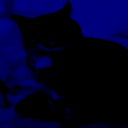

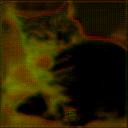

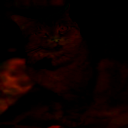

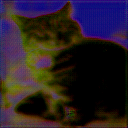

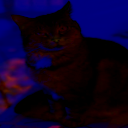

Start training epoch 2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[2/10] - using time: 9.80
loss of mainNet: 746.900
loss of netLH: 5.743
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


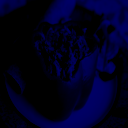

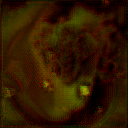

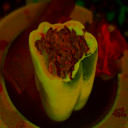

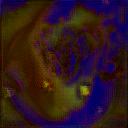

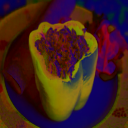

Start training epoch 3


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[3/10] - using time: 9.69
loss of mainNet: 684.173
loss of netLH: 5.740
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


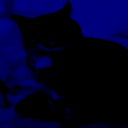

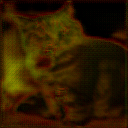

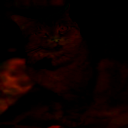

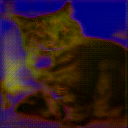

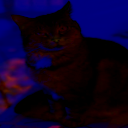

Start training epoch 4


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[4/10] - using time: 9.75
loss of mainNet: 643.750
loss of netLH: 5.746
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


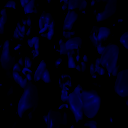

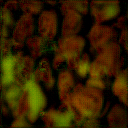

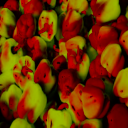

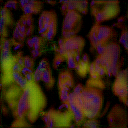

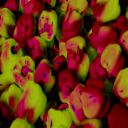

Start training epoch 5


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[5/10] - using time: 9.63
loss of mainNet: 622.950
loss of netLH: 5.741
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


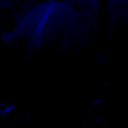

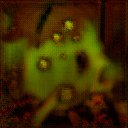

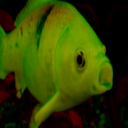

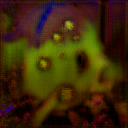

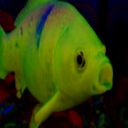

Start training epoch 6


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[6/10] - using time: 9.84
loss of mainNet: 465.923
loss of netLH: 5.720
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


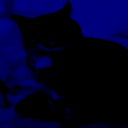

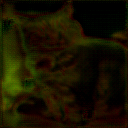

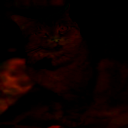

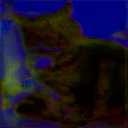

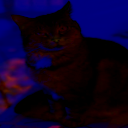

Start training epoch 7


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[7/10] - using time: 9.68
loss of mainNet: 414.293
loss of netLH: 5.707
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


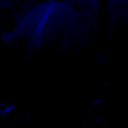

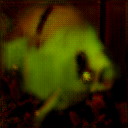

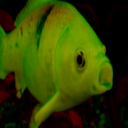

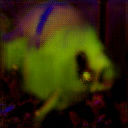

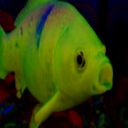

Start training epoch 8


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[8/10] - using time: 9.71
loss of mainNet: 398.155
loss of netLH: 5.703
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


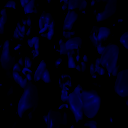

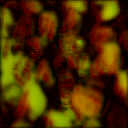

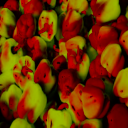

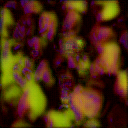

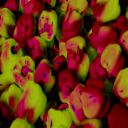

Start training epoch 9


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[9/10] - using time: 9.60
loss of mainNet: 340.371
loss of netLH: 5.712
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


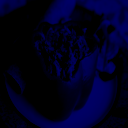

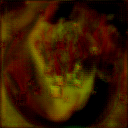

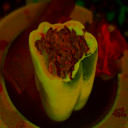

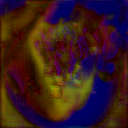

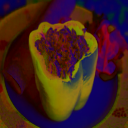

Start training epoch 10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for 

[10/10] - using time: 9.71
loss of mainNet: 395.134
loss of netLH: 5.730
Sample Image:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


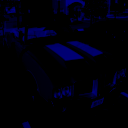

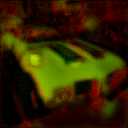

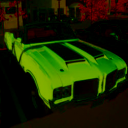

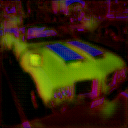

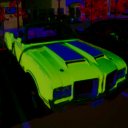

In [0]:
# train the models
mainNet, netLH, netGH, color_loss_history, distribution_loss_history = train(mainNet, netLH, netGH, train_data, save_dir = None, num_epochs=10)

In [0]:
# trash !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def try_Z(train_loader):
    for inputs, _ in train_loader:
        inputs = (inputs + 1)/2 # normalize to [0,1]
        # torch.cuda.set_device(device)
        inputs = inputs.to(device)
        inputs, real_LAB = filter_inputs(inputs)
        if inputs==None:
            continue
        else:
            # transfer into Lab space
            real_L = real_LAB[:,[0,],:,:] 
            real_AB = real_LAB[:,1:,:,:] 
            
            # get hints and ground truth Z
            user_hint = get_user_hint(real_AB)
            glob_hint = get_glob_hint(inputs, real_LAB)
            Z = get_color_distr(real_AB) # (N,H,W)
            print(Z.shape)

try_Z(train_data)

7. Test

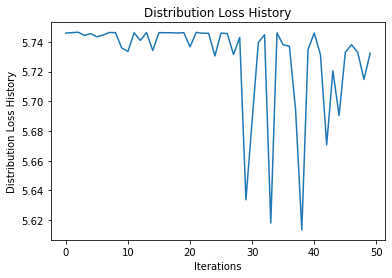

In [0]:
# Test more images of the testing data
x2 = np.arange(50)

plt.figure()
plt.plot(x2, distribution_loss_history)
plt.xlabel('Iterations')
plt.ylabel('Distribution Loss History')
plt.title('Distribution Loss History')
plt.show()